In [1768]:
from math import sqrt, log, log10

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model

%matplotlib inline  

In [1259]:
def moving_average(a, n=3) :
    cum = np.cumsum(a, dtype=float)
    ret = cum + 0
    for i in range(len(ret)):
        if i < n:
            ret[i] = cum[i] / (i+1)
        else:
            ret[i] = (cum[i] - cum[i-n])/n
    return ret

In [1730]:
def fit_block(x, y, nb_adaptative_steps=1000, moving_average_size=1000):
    n = x.shape[0]
    p = x.shape[1]
    
    max_iterations = max(1000000, n)
    a = 1
    alphas = np.zeros(nb_adaptative_steps + 1)
    b = np.ones(p)
    errors = np.zeros(max_iterations)
    
    for i in range(1, max_iterations):
        row = i % n
        e = np.inner(x[row], b) - y[row]
        b -= a * x[row] * e
        errors[i-1] = abs(e)

        if i <= nb_adaptative_steps:
            e_updated = np.inner(x[row], b) - y[row]
            if abs(e_updated) > abs(e):
                a *= (1 - 0.999**i)
            else:
                a *= 1.1
            alphas[i-1] = a
            if i == nb_adaptative_steps:
                a = np.average(alphas)
                alphas[i] = a
            
        #if i % 10000 == 0:
        #    log_trailing_error = np.average(errors[i-moving_average_size:i])
        #    log_trailing_error_before = np.average(errors[i-max(i // 10, 10000):i-max(i // 10, 10000) + moving_average_size])
        #    if log_trailing_error >= log_trailing_error_before:
        #        break
        
    nb_betas = min(i, n)
    betas = np.zeros(p)
    for j in range(nb_betas):
        row = (i + j) % n
        e = np.inner(x[row], b) - y[row]
        b -= a * x[row] * e
        betas += b 
    betas  /= nb_betas
    
    return (i, betas, alphas, errors[:i])

In [1839]:
def arrray_iterator(x, y):
    size = x.shape[0]
    i = 0
    while True:
        yield (x[i % size], y[i % size])
        i += 1
        
def file_iterator(file_name):
    while True:
        with open(file_name, 'r') as data_file:
            values = data_file.readline().split(',')
            values = list(map(float, values))
            yield(np.array(values[:-1]), values[-1])

In [1840]:
def fit_online(n, p, xy_iterator, fit_intercept=True, nb_adaptative_steps=1000, moving_average_size=1000, p1=0, p2=0):
    max_iterations = max(1000000, n)
    a = 1
    alphas = np.zeros(nb_adaptative_steps + 1)
    intercept = 0
    b = np.ones(p)
    errors = np.zeros(max_iterations)
    
    for i in range(1, max_iterations):
        x, y = next(xy_iterator)
        if i == 1:
            print (x, y)
        e = np.inner(x, b) + intercept - y 
        e_regularized = e + np.sum(p1 * np.abs(b) + p2 * np.square(b))
        if fit_intercept:
            intercept -= a * e * 100
        b -= (a * e) * x + p1 * np.sign(b) + p2 * b
        errors[i-1] = abs(e)

        if i <= nb_adaptative_steps:
            e_updated = np.inner(x, b) + intercept - y + np.sum(p1 * np.abs(b) + p2 * np.square(b))
            if abs(e_updated) > abs(e_regularized):
                a *= (1 - 0.999**min(i, 1000))
            else:
                a *= 1.1
            alphas[i-1] = a
            if i == nb_adaptative_steps:
                a = np.average(alphas)
                alphas[i] = a
            
        if i % 10000 == 0:
            log_trailing_error = np.average(errors[i-moving_average_size:i])
            log_trailing_error_before = np.average(errors[i-max(i // 10, 10000):i-max(i // 10, 10000) + moving_average_size])
            if log_trailing_error >= log_trailing_error_before:
                break
    
    a = np.average(alphas)
    nb_betas = min(i, n)
    intercepts = 0
    betas = np.zeros(p)
    for j in range(nb_betas):
        x, y = next(xy_iterator)
        e = np.inner(x, b) + intercept - y
        if fit_intercept:
            intercept -= a * e
        b -= (a * e) * x + p1 * np.sign(b) + p2 * b
        intercepts += intercept
        betas += b 
    intercepts /= nb_betas
    betas  /= nb_betas
    
    return (i, intercepts, betas, alphas, errors[:i])

In [1863]:
p = 10
n = 100000


beta = np.random.random(p) #* 2 - 1

x = np.random.random(p * n).reshape((n, p,))
#x = np.hstack((np.ones((n, 1)), x))
y = np.dot(x, beta) + np.random.normal(size=n) / 1000 + 1

In [1865]:
with open('data.csv', 'w') as data_file:
    for i in range(len(x)):
        line = list(x[i]) + [y[i]]
        data_file.write(','.join(map(lambda x: str(round(x, 3)), line)) + '\n')

In [1866]:
x


array([[ 0.31691897,  0.15466947,  0.48020593, ...,  0.66381595,
         0.24710938,  0.25916909],
       [ 0.62137053,  0.12031181,  0.65236073, ...,  0.76411381,
         0.54893862,  0.19947662],
       [ 0.0897673 ,  0.24574477,  0.48359382, ...,  0.38425705,
         0.46406855,  0.66819164],
       ..., 
       [ 0.50504186,  0.73121018,  0.19352571, ...,  0.67812181,
         0.97262728,  0.32164077],
       [ 0.79397674,  0.04705617,  0.54703893, ...,  0.21013751,
         0.89145507,  0.97833492],
       [ 0.36554   ,  0.76436275,  0.61310614, ...,  0.85533175,
         0.03314254,  0.63743971]])

In [1867]:
fi =file_iterator('data.csv')
ai = arrray_iterator(x, y)
for i in range(10):
    x, y = next(fi)
    w, z = next(ai)
    print(x-w, y-z)
    print(x, y)
    print(w, z)

[  8.10308171e-05   3.30530904e-04  -2.05934469e-04  -3.79083449e-04
   3.48172789e-04   1.44359021e-04  -4.62048486e-04   1.84054351e-04
  -1.09381358e-04  -1.69091121e-04] 0.000163417978681
[ 0.317  0.155  0.48   0.564  0.318  0.938  0.377  0.664  0.247  0.259] 3.295
[ 0.31691897  0.15466947  0.48020593  0.56437908  0.31765183  0.93785564
  0.37746205  0.66381595  0.24710938  0.25916909] 3.29483658202
[-0.30437053  0.03468819 -0.17236073 -0.13629807  0.14019903  0.08204372
 -0.37808754 -0.10011381 -0.30193862  0.05952338] -0.482138386437
[ 0.317  0.155  0.48   0.564  0.318  0.938  0.377  0.664  0.247  0.259] 3.295
[ 0.62137053  0.12031181  0.65236073  0.70029807  0.17780097  0.85595628
  0.75508754  0.76411381  0.54893862  0.19947662] 3.77713838644
[ 0.2272327  -0.09074477 -0.00359382 -0.16391265  0.0777019   0.65699005
  0.06990813  0.27974295 -0.21706855 -0.40919164] 0.133660269539
[ 0.317  0.155  0.48   0.564  0.318  0.938  0.377  0.664  0.247  0.259] 3.295
[ 0.0897673   0.2457447

[ 0.047  0.521  0.42   0.189  0.718  0.064  0.36   0.348  0.657  0.016] 2.613
minimum achieved at : 80
lambda :  4.93040163622e+33
error :  0.0
20000 th iteration
intercept :  -0.714931948706
Trailing error :  [ 0.]
Difference of coefficient : 4.95397649044 [ 0.52279158  0.26048464  0.56656967  0.51701802  0.36386301]
NB of non null coefficients :  10
Mean squared error : 0.84
Sum of log10 abs error :  -0.10142875894761438


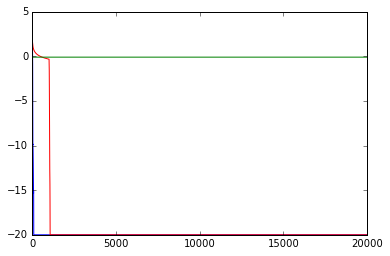

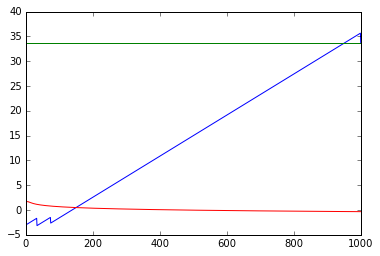

[ 0.99966398  0.9962752   0.99699729  0.99864878  0.99486679  0.99954244
  0.99742624  0.99751204  0.9953029   0.99988561]


In [1849]:
#i, intercept, b, l, errors = fit_online(x.shape[0], x.shape[1], arrray_iterator(x, y), p1=0)
i, intercept, b, l, errors = fit_online(x.shape[0], x.shape[1], file_iterator('data.csv'), p1=0)
trailing_errors = moving_average(errors, 1000)

print('minimum achieved at :', np.argmin(errors))
print('lambda : ', l[-1])
print('error : ', errors[-1])
print(i, 'th iteration')
print('intercept : ', intercept)
print('Trailing error : ', trailing_errors[-1:])
print("Difference of coefficient :", np.sum(abs(beta - b)), abs((b-beta)[:5]))
print('NB of non null coefficients : ', np.count_nonzero(np.greater(b, 0.01)))
print("Mean squared error : %.2f" % np.mean(np.square((np.inner(x, b) + intercept - y))))
e = np.average(np.abs(np.inner(x, b) + intercept - y))
print("Sum of log10 abs error : ", log10(e))

fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(errors + 1e-20))
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(trailing_errors + 1e-20), color='red')
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.ones(len(errors))*np.log10(e), color='green')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.log10(l + 1e-20))
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.log10(trailing_errors + 1e-20)[:len(l)], color='red')
ax = fig.add_subplot(111)
line, = ax.plot(range(len(l)), np.ones(len(l))*np.log10(l[-1] + 1e-20), color='green')
plt.show()
print(b)

In [1802]:
regr = linear_model.SGDRegressor(fit_intercept=True)
regr.fit(x, y)

# The mean squared error
print("Difference of coefficient :", np.sum(abs(beta - regr.coef_)))
x_hat = regr.predict(x)
print("Mean squared error: %.2f" % np.mean(np.square((x_hat - y))))
print("Sum of log10 abs error : ", log10(np.average(np.abs(x_hat - y))))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % regr.score(x, y))

Difference of coefficient : 0.313905930658
Mean squared error: 0.00
Sum of log10 abs error :  -2.512939001517372


In [5]:
%%timeit
i, b, l, errors, trailing_errors = fit(x, y)

10 loops, best of 3: 61.9 ms per loop


In [ ]:
def fit(x, y, l=0.001):
    epsilon = 1e-20
    batch_size = x.shape[1]
    moving_average_size = 20
    
    b = np.zeros(p)
    errors =[]
    trailing_errors =[]
    i = 0
    while True:
        row = (i * batch_size) % n
        e = (np.dot(x[row:row + batch_size], b) - y[row:row + batch_size]) / batch_size
        b = b - np.dot(x[row:row + batch_size].transpose(), e) * l
        errors.append(np.sum(np.abs(e)) + epsilon)
        trailing_errors.append(np.average(errors[-moving_average_size:]))
        #if errors[-1] > errors[0] * 2:
        #    print(i, errors[-1], errors[0])
        #    return (i, b, l,errors, trailing_errors)
        if (i > 10 * n / batch_size):# or (i >= 20 and log10(trailing_errors[-1]) > log10(trailing_errors[-max(i // 10, moving_average_size)])):
            return (i, b, l,errors, trailing_errors)
        i += 1
    

def fit_schedule(x, y, eta0=0.1, power_t=0.6):
    epsilon = 1e-20
    moving_average_size = 100
    p = x.shape[1]
    
    b = np.zeros(p)
    errors =[]
    trailing_errors =[]
    i = 1
    while True:
        row = i % n
        e = np.inner(x[row], b) - y[row]
        b = b - x[row] * e * eta0 / i**power_t
        #print(eta0/i**power_t)
        errors.append(abs(e) + epsilon)
        trailing_errors.append(np.average(errors[-moving_average_size:]))
        if(trailing_errors[-1] > trailing_errors[0] * 1.5):
            b = np.zeros(p)
        if (i > 100000): 
            return (i, b, l,errors, trailing_errors)
        i += 1
        

In [716]:
def fit_schedule_batch(x, y, eta0=0.1, power_t=0.6):
    epsilon = 1e-20
    p = x.shape[1]
    batch_size = 10
    moving_average_size = 10
    
    b = np.zeros(p)
    errors =[]
    trailing_errors =[]
    i = 1
    while True:
        row = (i * batch_size) % n
        e = (np.dot(x[row:row + batch_size], b) - y[row:row + batch_size]) / batch_size
        b = b - np.dot(x[row:row + batch_size].transpose(), e) * eta0 / i**power_t
        errors.append(np.sum(np.abs(e)) + epsilon)
        trailing_errors.append(np.average(errors[-moving_average_size:]))
        if(trailing_errors[-1] > trailing_errors[0] * 1.2):
            b = np.zeros(p)
        if (i > 100000 / batch_size): 
            return (i, b, l,errors, trailing_errors)
        i += 1

lambda :  1.0408277903093217
error :  0.00314086758854
10001 th iteration - trailing error:  [0.0029291921904411326]
Difference of coefficient : 0.0169987943789
Mean squared error: 0.00
Sum of log10 abs error :  -2.545981279626473


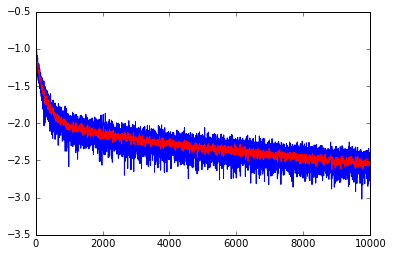

In [760]:
eta0 = 0.1
power_t = 0.5

i, b, l, errors, trailing_errors = fit_schedule_batch(x, y, eta0, power_t)

print('lambda : ', l)
# print('coeff for trailing error : ', coeff_trailing_error)
print('error : ', errors[-1])
print(i, 'th iteration - trailing error: ', trailing_errors[-1:])
print("Difference of coefficient :", np.sum(abs(beta - b)))
print("Mean squared error: %.2f" % np.mean(np.square((np.dot(x, b) - y))))
print("Sum of log10 abs error : ", log10(np.average(np.abs(np.inner(x, b) - y))))

fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(errors))
ax = fig.add_subplot(111)
line, = ax.plot(range(len(errors)), np.log10(trailing_errors), color='red')
plt.show()

In [ ]:
def fit_basic(x, y, l=0.001):
    epsilon = 1e-20
    moving_average_size = 20
    
    b = np.zeros(p)
    errors =[]
    trailing_errors =[]
    i = 0
    while True:
        row = i % n
        e = np.inner(x[row], b) - y[row]
        b = b - x[row] * e * l
        errors.append(abs(e) + epsilon)
        trailing_errors.append(np.average(errors[-moving_average_size:]))
        #if errors[-1] > errors[0] * 2:
        #    print(i, errors[-1], errors[0])
        #    return (i, b, l,errors, trailing_errors)
        if (i > 10 * n): # or (i >= moving_average_size and log10(trailing_errors[-1]) > log10(trailing_errors[-max(i // 10, moving_average_size)])):
            return (i, b, l,errors, trailing_errors)
        i += 1
   

In [ ]:
def fit_block(x, y, l=0.5):
    epsilon = 1e-20
    n = x.shape[0]
    batch_size = 1 #x.shape[1]
    moving_average_size = 1000
    
    b = np.ones(p)
    errors =[]
    trailing_errors =[]
    i = 0
    while True:
        row = (i * batch_size) % n
        e = (np.dot(x[row:row + batch_size], b) - y[row:row + batch_size]) / batch_size
        b2 = b - np.dot(x[row:row + batch_size].transpose(), e) * l
        e2 = (np.dot(x[row:row + batch_size], b2) - y[row:row + batch_size]) / batch_size
        if sum(abs(e2)) > sum(abs(e)):
            l = l * 0.3
        else:
            l = l * 1.02
        b = b2
        e = e2
        errors.append(np.sum(np.abs(e)) + epsilon)
        trailing_errors.append(np.average(errors[-moving_average_size:]))
        if (i > 1000000) or (i >= 10000 and log10(trailing_errors[-1]) > log10(trailing_errors[-max(i // 10, moving_average_size)])):
            return (i, b, l,errors, trailing_errors)
        i += 1